In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [2]:
# === PATHS & PARAMETERS ===
dataset_path = 'dataset-resized'  # Update if your path differs
img_height, img_width = 224, 224
batch_size = 32
epochs = 40

In [3]:
# === IMAGE DATA GENERATOR WITH AUGMENTATION ===
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

In [4]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 2024 images belonging to 6 classes.


In [5]:
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 503 images belonging to 6 classes.


In [9]:
# === COMPUTE CLASS WEIGHTS FOR BALANCING ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [10]:
# === LOAD BASE MODEL (TRANSFER LEARNING) ===
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet',
    alpha=0.5  # lightweight model
)

In [11]:
# === FINE-TUNE LAST 50 LAYERS ===
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [12]:
# === CUSTOM CLASSIFICATION HEAD ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

In [13]:
# === DEFINE FINAL MODEL ===
model = Model(inputs=base_model.input, outputs=output)


In [14]:
# === COMPILE MODEL WITH PRECISION & RECALL ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

In [15]:
# === CALLBACKS ===
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_trashnet.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
]

In [16]:
# === TRAIN THE MODEL ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/40
64/64 [==============================] - 53s 779ms/step - loss: 1.7461 - accuracy: 0.3093 - precision: 0.5115 - recall: 0.0548 - val_loss: 1.4097 - val_accuracy: 0.4811 - val_precision: 0.8529 - val_recall: 0.0577 - lr: 1.0000e-04


C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
64/64 [==============================] - 33s 512ms/step - loss: 1.3084 - accuracy: 0.5128 - precision: 0.7784 - recall: 0.2169 - val_loss: 1.3412 - val_accuracy: 0.4493 - val_precision: 0.5643 - val_recall: 0.1571 - lr: 1.0000e-04
Epoch 3/40
64/64 [==============================] - 34s 526ms/step - loss: 1.0577 - accuracy: 0.6240 - precision: 0.7929 - recall: 0.4066 - val_loss: 1.2780 - val_accuracy: 0.5149 - val_precision: 0.6314 - val_recall: 0.3201 - lr: 1.0000e-04
Epoch 4/40
64/64 [==============================] - 34s 529ms/step - loss: 0.9145 - accuracy: 0.6729 - precision: 0.8031 - recall: 0.5119 - val_loss: 1.2833 - val_accuracy: 0.5089 - val_precision: 0.5740 - val_recall: 0.3777 - lr: 1.0000e-04
Epoch 5/40
64/64 [==============================] - 34s 527ms/step - loss: 0.7802 - accuracy: 0.7248 - precision: 0.8199 - recall: 0.6097 - val_loss: 1.4356 - val_accuracy: 0.4692 - val_precision: 0.5227 - val_recall: 0.3658 - lr: 1.0000e-04
Epoch 6/40
64/64 [==============

In [18]:
# === FINAL EVALUATION ===
results = model.evaluate(val_generator)

# Extract values by position or name
val_loss = results[0]
val_accuracy = results[1]
val_precision = results[2]
val_recall = results[3]

print(f"\n✅ Final Evaluation Metrics:")
print(f"   🔹 Loss     : {val_loss:.4f}")
print(f"   🔹 Accuracy : {val_accuracy * 100:.2f}%")
print(f"   🔹 Precision: {val_precision * 100:.2f}%")
print(f"   🔹 Recall   : {val_recall * 100:.2f}%")

16/16 [==============================] - 6s 344ms/step - loss: 0.7090 - accuracy: 0.7396 - precision: 0.7879 - recall: 0.7018

✅ Final Evaluation Metrics:
   🔹 Loss     : 0.7090
   🔹 Accuracy : 73.96%
   🔹 Precision: 78.79%
   🔹 Recall   : 70.18%


16/16 [==============================] - 6s 339ms/step


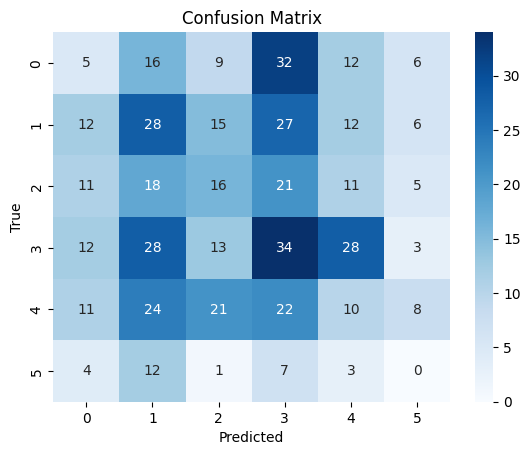

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation data
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(val_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
